# Lab CMBLenses

## Model

In [1]:
] activate "/home/jaimerz/julia_repos/CMBLensingInferenceTestProblem"

  Activating project at `~/julia_repos/CMBLensingInferenceTestProblem`


In [70]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

In [3]:
using Revise
using MCHMC

In [4]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 4);

MAP_joint: 100%|████████████████████████████████████████| Time: 0:00:47
  step:        20
  logpdf:      377.00
  α:           0.008522608
  CG:          2 iterations
  Linesearch:  9 bisections


In [5]:
target = CMBLensingTarget(prob)

CMBLensingTarget(50, [-0.30936679244041443 0.0 … 0.0 0.0; 0.0 -0.8185905814170837 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], MCHMC.var"#nlogp#26"{CMBLensingInferenceTestProblem.CMBLensingLogDensityProblem}(CMBLensingInferenceTestProblem.CMBLensingLogDensityProblem(BaseDataSet(d, Cf, Cn, Cn̂, M, M̂, B, B̂, logprior, Cϕ, Cf̃, D, G, L, Nϕ), [0.23362982273101807, 1.6145217418670654, -1.8872356414794922, -3.2767221927642822, 0.8644531965255737, 2.2458934783935547, -1.246073603630066, -2.639155864715576, 1.868626356124878, 3.251345157623291  …  -3.395840053599386e-9, 3.6597669339499816e-11, 4.677404241704153e-9, 1.211756028851596e-9, -5.810230518932258e-9, -2.3360031686792126e-9, 2.561251877253312e-9, -9.142808177209361e-10, -1.6094379124341003, 0.0], [0.0064222607761621475, 1.912354826927185, -2.338594675064087, -2.761254072189331, 0.3457961082458496, 2.8930203914642334, -1.2424980401992798, -3.303896427154541, 1.9643025398254395, 3.0344090461730957  …  -3.2332728494566254e-8, -3

## Sample

In [62]:
eps=0.00000001
L=sqrt(target.d)
spl=Sampler(;eps=eps, L=L)

Sampler(Settings(MersenneTwister(0), 1.0e-8, 7.0710678118654755, 0.0, 0.1931833275037836, 0.0005, 2000, 1000, 10, "LF"), MCHMC.Leapfrog)

In [112]:
init = MCHMC.Get_initial_conditions(spl, target; initial_x=target.Λmass*prob.Ωstart)

([-0.07227730751037598, -1.3216322660446167, 1.1293165683746338, 2.6822938919067383, 0.8535043597221375, -0.9474374055862427, 1.0418479442596436, -1.855589509010315, 1.6437256336212158, 0.340961754322052  …  -7.0131552e7, -446595.09375, 4.384656e7, -1.4786851e7, 1.26009488e8, -2.944091e7, -2.384044e7, -1.1522784e7, -1.6094379124341003, 0.0], [-0.1909991055727005, -0.1120356023311615, -0.09257126599550247, 0.2711433470249176, -0.03951350226998329, 0.038242705166339874, 0.20655348896980286, -0.11284273862838745, -0.18359340727329254, -0.07829532772302628  …  0.015142692252993584, -0.29925885796546936, -0.12097357958555222, -0.10131928324699402, -0.11907980591058731, -0.07851103693246841, -0.09651341289281845, 0.11246967315673828, -0.1361217759957897, 0.032927639504442566], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -Inf, -Inf], -Inf, 0.0)

In [111]:
init = MCHMC.Get_initial_conditions(spl, target; initial_x=prob.Ωstart)

([0.23362982273101807, 1.6145217418670654, -1.8872356414794922, -3.2767221927642822, 0.8644531965255737, 2.2458934783935547, -1.246073603630066, -2.639155864715576, 1.868626356124878, 3.251345157623291  …  -3.395840053599386e-9, 3.6597669339499816e-11, 4.677404241704153e-9, 1.211756028851596e-9, -5.810230518932258e-9, -2.3360031686792126e-9, 2.561251877253312e-9, -9.142808177209361e-10, -1.6094379124341003, 0.0], [0.15115304291248322, -0.0759209617972374, -0.06779322028160095, 0.049383316189050674, -0.09404236078262329, -0.047861214727163315, -0.2316562831401825, 0.03092900849878788, -0.04149305075407028, -0.10878290235996246  …  -0.03412190452218056, -0.029930416494607925, 0.05249309167265892, -0.1123279482126236, 0.37369877099990845, -0.10521980375051498, -0.07317271083593369, -0.015007216483354568, -0.12208623671953696, 0.16572749713693474], [-3.002088817538606e-7, 3.2172076203096367e-7, -5.61635943086003e-7, -5.00593102970015e-7, 1.5009730702786328e-7, 1.0105396768267383e-6, -7.816

In [107]:
MCHMC.step(spl, target, init)

LoadError: MethodError: no method matching step(::Sampler, ::CMBLensingTarget, ::Tuple{Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}, Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}, Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}, Float64, Float64})

In [109]:
samples = Sample(spl, target; num_steps=100)

100-element Vector{Vector{Float64}}:
 [0.23362981840493835, 1.614521741586634, -1.887235640617166, -3.276722192062893, 0.8644531964439024, 2.2458934776063253, -1.2460736015850433, -2.6391558645093127, 1.8686263581768743, 3.2513451562747346  …  -1.9282478910350277e-9, -4.674597749092131e-10, 5.685023209636846e-9, -2.7505254740796294e-10, -7.886997485344893e-9, -2.310630886125085e-9, 1.962352968531825e-9, -4.0494485472716385e-10, -1.6094379136524397, -7.936760922135325e-10]
 [0.2336298139417153, 1.6145217412972608, -1.8872356397274501, -3.2767221913393656, 0.8644531963596438, 2.2458934767941883, -1.246073599475214, -2.6391558642964807, 1.8686263602938167, 3.251345154883491  …  -8.025769185412164e-10, -6.011964628775073e-10, 6.2891964364327414e-9, -1.3778011683808862e-9, -9.664373473047784e-9, -2.64225263800832e-9, 1.74533675378859e-9, -2.812093213353739e-10, -1.6094379149094142, -1.6125934937925474e-9]
 [0.23362980943336706, 1.6145217410050607, -1.8872356388288576, -3.2767221906085617, 0

In [95]:
inv_Λmass = Diagonal(Vector(diag(pinv(target.Λmass))))

50×50 Diagonal{Float64, Vector{Float64}}:
 -3.23241    ⋅         ⋅        ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
   ⋅       -1.22161    ⋅        ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
   ⋅         ⋅       -1.67113   ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋮                                      ⋱            ⋮                   
   ⋅         ⋅         ⋅        ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
   ⋅         ⋅         ⋅        ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

In [96]:
t_samples = [inv_Λmass * sample for sample in samples]

1000-element Vector{Vector{Float64}}:
 [-0.7551871422419684, -1.9723189044399916, 3.153817341010013, 4.00288268152394, 0.8755424965047737, -5.323874091863848, 1.4903320772163018, -3.7536018109628206, 2.124298863474109, 31.004195695339554  …  -1.1090732105678145e-25, -2.429280109436353e-25, 6.079122544906053e-25, -2.0881785403585004e-25, 2.513874290434453e-25, 2.2048211456580568e-26, 5.754487323849558e-26, -1.8290226309332736e-25, -1.609437912125781, 4.2394004564755625e-10]
 [-0.755187142738394, -1.9723189049741952, 3.1538173442645228, 4.002882678853941, 0.8755424943142832, -5.323874095574684, 1.4903320746574957, -3.7536018146889147, 2.124298861692795, 31.00419569679614  …  -5.609598967872978e-26, -4.969460424199534e-25, 7.029110632367255e-25, -3.148756099432343e-25, 2.2783591277920346e-25, 2.12984026069455e-25, 3.6456816301727085e-25, -3.0101381720595403e-25, -1.6094379118102224, 8.575922323792269e-10]
 [-0.7551871432526479, -1.9723189055272705, 3.1538173476345497, 4.002882676089195, 0

## Plotting

In [97]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [98]:
rs = [sample[end] for sample in samples]
Aϕs = [sample[end-1] for sample in samples];

In [99]:
println(mean(exp.(rs)), " ", std(exp.(rs)))

1.0000002421361862 1.3971494968619249e-7


In [100]:
println(mean(exp.(Aϕs)), " ", std(exp.(Aϕs)))

0.2000000352492964 2.0308498979354448e-8


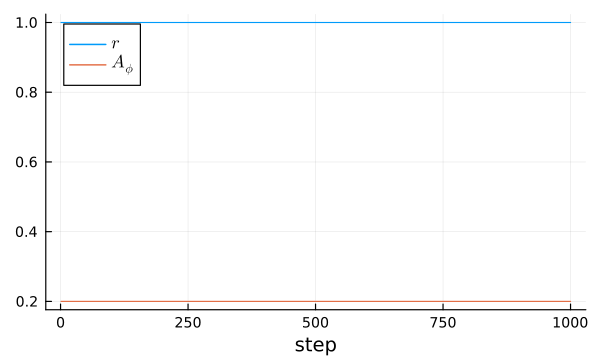

In [101]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")

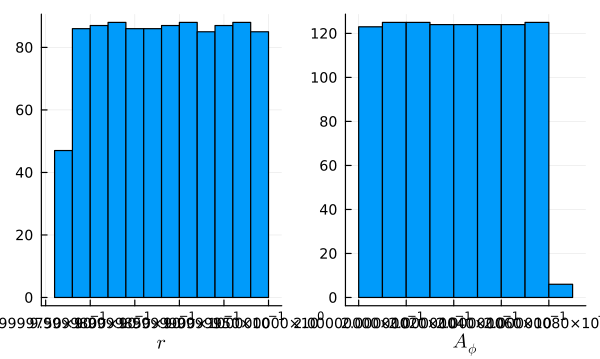

In [61]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))